In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import math

## Read the train, validation and test data with predictions

In [2]:
data_train = pd.read_csv('../data/data_train.csv')
data_val = pd.read_csv('../data/data_val.csv')
data_test = pd.read_csv('../data/data_test.csv')


## Helper Functions

## Strategies

In [3]:
data_train[['Open', 'High', 'pred_high_open', 'actual_high_open', 'Low', 'pred_low_open', 'actual_low_open',  'Close', ]]

,Open,High,pred_high_open,actual_high_open,Low,pred_low_open,actual_low_open,Close
0,545.760010,550.479980,1.716057,4.719970,542.479980,-1.269214,-3.280030,542.719971
1,540.000000,551.919983,1.718816,11.919983,539.200012,-2.755045,-0.799988,550.559998
2,553.599976,559.200012,1.392747,5.600036,549.440002,-2.925629,-4.159974,558.320007
3,567.119995,585.840027,1.693658,18.720032,566.400024,-5.686240,-0.719971,582.479980
4,571.200012,579.599976,6.318321,8.399964,566.320007,-15.346693,-4.880005,568.080017
...,...,...,...,...,...,...,...,...
2480,76.580002,76.610001,1.662059,0.029999,74.620003,-1.180776,-1.959999,75.419998
2481,77.709999,79.180000,3.730509,1.470001,77.160004,-11.217957,-0.549995,78.989998
2482,78.629997,78.889999,5.934797,0.260002,77.870003,-8.335407,-0.759994,78.389999
2483,79.370003,81.750000,1.047133,2.379997,78.940002,-1.703301,-0.430001,81.680000


### Blind Strat

In [4]:
def blind_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, plot_capital=False):
    pnl = []

    capital = 10000

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0

    capital_list = []

    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open
        
        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
    
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)


    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

In [ ]:
delta_percents = np.arange(0, 0.02, 0.0001)

best_avg_pnl = -1 * float('inf')
best_delta_percent = None
best_pnl = None
best_profit_days = None
best_loss_days = None
best_neutral_days = None
best_capital = -1 * float('inf')

for delta_percent in delta_percents:
    pnl, num_profit_days, num_loss_days, num_neutral_days, capital = blind_strat(data_train, delta_percent=delta_percent)
   
    avg_pnl = sum(pnl) / len(pnl)

    if avg_pnl > best_avg_pnl:
        best_avg_pnl = avg_pnl
        best_delta_percent = delta_percent
        best_pnl = pnl
        best_profit_days = num_profit_days
        best_loss_days = num_loss_days
        best_neutral_days = num_neutral_days
    
    if capital > best_capital:
        best_capital = capital
        best_avg_pnl = avg_pnl
        best_delta_percent = delta_percent
        best_pnl = pnl
        best_profit_days = num_profit_days
        best_loss_days = num_loss_days
        best_neutral_days = num_neutral_days

    print(f"Delta = {delta_percent*100}% ====> Average PNL = {avg_pnl}$, Profitable Days = {num_profit_days}, Lossy Days = {num_loss_days}, Neutral Days = {num_neutral_days}, Sum PnL = {sum(pnl)}")

print()

print(f'Best Delta = {best_delta_percent*100}% ===> Best Average PNL = {best_avg_pnl}$, Profitable Days = {best_profit_days}, Lossy Days = {best_loss_days}, Neutral Days = {best_neutral_days}, Capital = {best_capital}')

plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
plt.xlabel('Days')
plt.ylabel('Profit in U.S. Dollars $')
plt.plot(best_pnl)


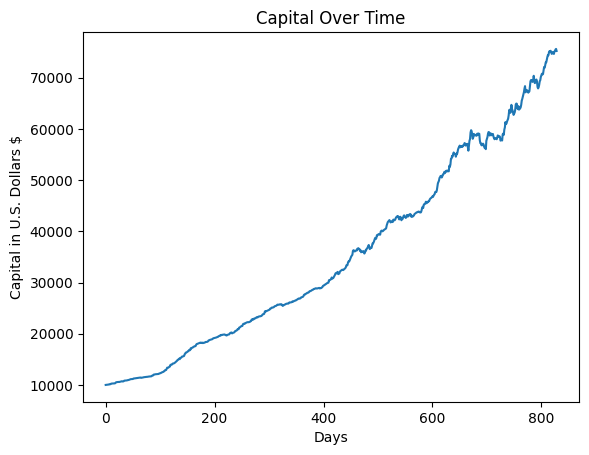

Capital = 75237.11582659505
Delta = 0.0% ===> Test Average PNL = 1.1757775985699692$, Profitable Days = 641, Lossy Days = 181, Neutral Days = 7, Sum PNL = 974.7196292145045, Capital 75237.11582659505


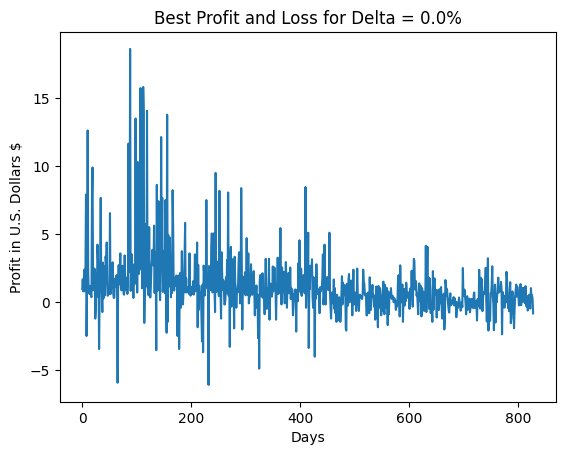

In [ ]:
test_pnl, test_num_profit_days, test_num_loss_days, test_num_neutral_days, capital = blind_strat(data_val, delta_percent=best_delta_percent, cap_alloc_limit=0.5)

test_avg_pnl = sum(test_pnl) / len(test_pnl)

print(f'Delta = {best_delta_percent*100}% ===> Test Average PNL = {test_avg_pnl}$, Profitable Days = {test_num_profit_days}, Lossy Days = {test_num_loss_days}, Neutral Days = {test_num_neutral_days}, Sum PNL = {sum(test_pnl)}, Capital {capital}')


plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
plt.xlabel('Days')
plt.ylabel('Profit in U.S. Dollars $')
plt.plot(test_pnl)

### Stoploss Strat

In [ ]:
def stoploss_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, plot_capital=False):
    pnl = []

    capital = 10000

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            # Elif Price dips below Open, then sell @ Open
            elif day_info["Low"] < day_info["Open"]:
                day_return = 0
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
        
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)

    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

Capital = 257790.90784073505
Delta = 0.0% ====> Average PNL = 2.427496953729563$, Profitable Days = 1017, Lossy Days = 12, Neutral Days = 1456, Sum PnL = 6032.329930017964
Capital = 257790.90784073505
Delta = 0.01% ====> Average PNL = 2.427496953729563$, Profitable Days = 1017, Lossy Days = 12, Neutral Days = 1456, Sum PnL = 6032.329930017964
Capital = 257790.90784073505
Delta = 0.02% ====> Average PNL = 2.427496953729563$, Profitable Days = 1017, Lossy Days = 12, Neutral Days = 1456, Sum PnL = 6032.329930017964
Capital = 257790.90784073505
Delta = 0.030000000000000002% ====> Average PNL = 2.427496953729563$, Profitable Days = 1017, Lossy Days = 12, Neutral Days = 1456, Sum PnL = 6032.329930017964
Capital = 257783.4764471138
Delta = 0.04% ====> Average PNL = 2.427421196321457$, Profitable Days = 1016, Lossy Days = 12, Neutral Days = 1457, Sum PnL = 6032.141672858821
Capital = 257309.6669763247
Delta = 0.05% ====> Average PNL = 2.4270729935066817$, Profitable Days = 1013, Lossy Days = 1

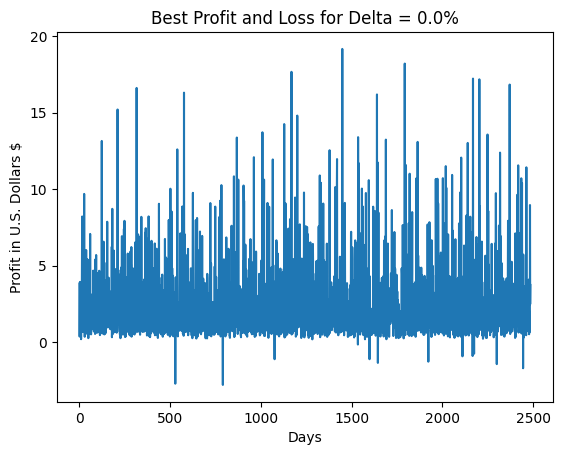

In [ ]:
delta_percents = np.arange(0, 0.02, 0.0001)

best_avg_pnl = -1 * float('inf')
best_delta_percent = None
best_pnl = None
best_profit_days = None
best_loss_days = None
best_neutral_days = None
best_capital = -1 * float('inf')

for delta_percent in delta_percents:
    pnl, num_profit_days, num_loss_days, num_neutral_days, capital = stoploss_strat(data_train, delta_percent=delta_percent)
   
    avg_pnl = sum(pnl) / len(pnl)

    if avg_pnl > best_avg_pnl:
        best_avg_pnl = avg_pnl
        best_delta_percent = delta_percent
        best_pnl = pnl
        best_profit_days = num_profit_days
        best_loss_days = num_loss_days
        best_neutral_days = num_neutral_days
    
    if capital > best_capital:
        best_capital = capital
        best_avg_pnl = avg_pnl
        best_delta_percent = delta_percent
        best_pnl = pnl
        best_profit_days = num_profit_days
        best_loss_days = num_loss_days
        best_neutral_days = num_neutral_days

    print(f"Delta = {delta_percent*100}% ====> Average PNL = {avg_pnl}$, Profitable Days = {num_profit_days}, Lossy Days = {num_loss_days}, Neutral Days = {num_neutral_days}, Sum PnL = {sum(pnl)}")

print()

print(f'Best Delta = {best_delta_percent*100}% ===> Best Average PNL = {best_avg_pnl}$, Profitable Days = {best_profit_days}, Lossy Days = {best_loss_days}, Neutral Days = {best_neutral_days}, Capital = {best_capital}')

plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
plt.xlabel('Days')
plt.ylabel('Profit in U.S. Dollars $')
plt.plot(best_pnl)


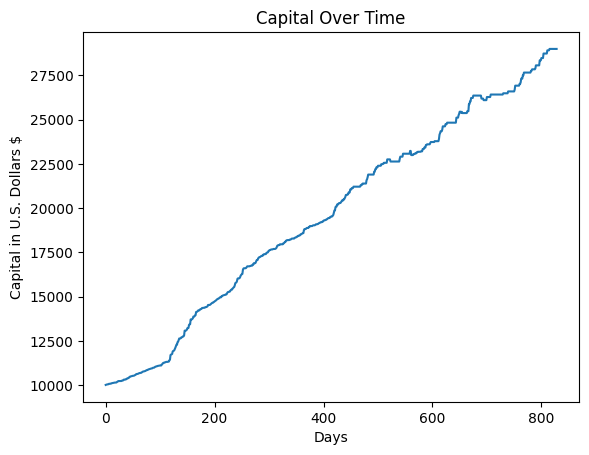

Capital = 28999.518451937736
Delta = 0.0% ===> Test Average PNL = 2.4207783640559386$, Profitable Days = 358, Lossy Days = 6, Neutral Days = 465, Sum PNL = 2006.825263802373, Capital 28999.518451937736


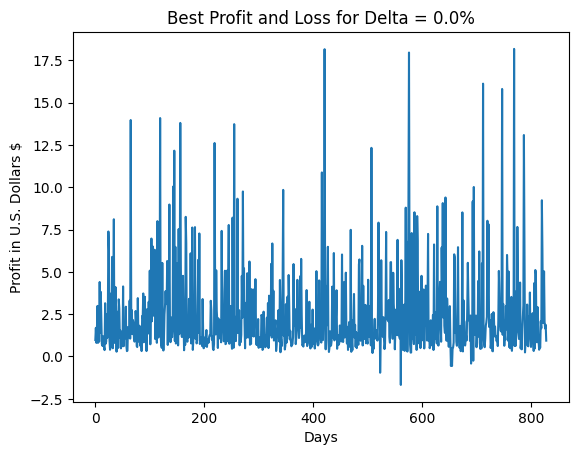

In [ ]:
test_pnl, test_num_profit_days, test_num_loss_days, test_num_neutral_days, capital = stoploss_strat(data_val, delta_percent=best_delta_percent, cap_alloc_limit=0.5)

test_avg_pnl = sum(test_pnl) / len(test_pnl)

print(f'Delta = {best_delta_percent*100}% ===> Test Average PNL = {test_avg_pnl}$, Profitable Days = {test_num_profit_days}, Lossy Days = {test_num_loss_days}, Neutral Days = {test_num_neutral_days}, Sum PNL = {sum(test_pnl)}, Capital {capital}')


plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
plt.xlabel('Days')
plt.ylabel('Profit in U.S. Dollars $')
plt.plot(test_pnl)

### Long + Short Strat

In [ ]:
def long_short_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, plot_capital=False):
    pnl = []

    capital = 10000

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        pred_low_delta = day_info["pred_low_open"]
        actual_low_delta = day_info["actual_low_open"]

        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        day_return_short = 0
        
        # Long Trade
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shares to buy
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(open-close)
        else:
            pnl.append(0)
            num_neutral_days += 1

        if pred_low_delta <= delta:
            if actual_low_delta <= pred_low_delta:
                day_return_short = pred_low_delta * -1
                num_shares = (capital * (1-cap_alloc_limit)) / open
                capital += math.floor(num_shares) * day_return_short
                pnl[-1] += pred_low_delta * -1
            else:
                day_return_short = (open-close) * -1
                num_shares = (capital * (1-cap_alloc_limit)) / open
                capital += math.floor(num_shares) * day_return_short
                pnl[-1] += pred_low_delta * -1

        # if day_return > 0 and day_return_short > 0:
            # print(f"Long Profit : {day_return} and Short Profit : {day_return_short}")


        if day_return + day_return_short > 0:
            num_profit_days += 1
        elif day_return + day_return_short < 0:
            num_loss_days += 1
        else:
            num_neutral_days += 1
        capital_list.append(capital)

    if plot_capital:    
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)
    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

In [ ]:
# delta_percents = np.arange(0, 0.02, 0.0001)

# best_avg_pnl = -1 * float('inf')
# best_delta_percent = None
# best_pnl = None
# best_profit_days = None
# best_loss_days = None
# best_neutral_days = None
# best_capital = -1 * float('inf')

# for delta_percent in delta_percents:
#     pnl, num_profit_days, num_loss_days, num_neutral_days, capital = long_short_strat(data_train, delta_percent=delta_percent)
   
#     avg_pnl = sum(pnl) / len(pnl)

#     if avg_pnl > best_avg_pnl:
#         best_avg_pnl = avg_pnl
#         best_delta_percent = delta_percent
#         best_pnl = pnl
#         best_profit_days = num_profit_days
#         best_loss_days = num_loss_days
#         best_neutral_days = num_neutral_days
    
#     if capital > best_capital:
#         best_capital = capital
#         best_avg_pnl = avg_pnl
#         best_delta_percent = delta_percent
#         best_pnl = pnl
#         best_profit_days = num_profit_days
#         best_loss_days = num_loss_days
#         best_neutral_days = num_neutral_days

#     print(f"Delta = {delta_percent*100}% ====> Average PNL = {avg_pnl}$, Profitable Days = {num_profit_days}, Lossy Days = {num_loss_days}, Neutral Days = {num_neutral_days}, Sum PnL = {sum(pnl)}")

# print()

# print(f'Best Delta = {best_delta_percent*100}% ===> Best Average PNL = {best_avg_pnl}$, Profitable Days = {best_profit_days}, Lossy Days = {best_loss_days}, Neutral Days = {best_neutral_days}, Capital = {best_capital}')

# plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
# plt.xlabel('Days')
# plt.ylabel('Profit in U.S. Dollars $')
# plt.plot(best_pnl)


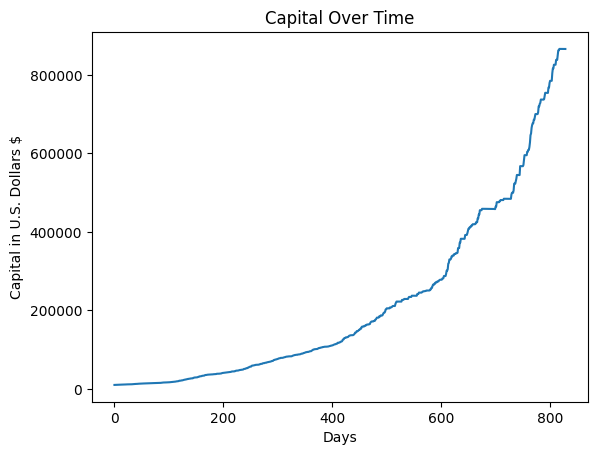

Capital = 866219.6699084259
Delta = 0.0% ===> Test Average PNL = 3.8742641327331784$, Profitable Days = 510, Lossy Days = 2, Neutral Days = 317, Sum PNL = 3211.7649660358047, Capital 866219.6699084259


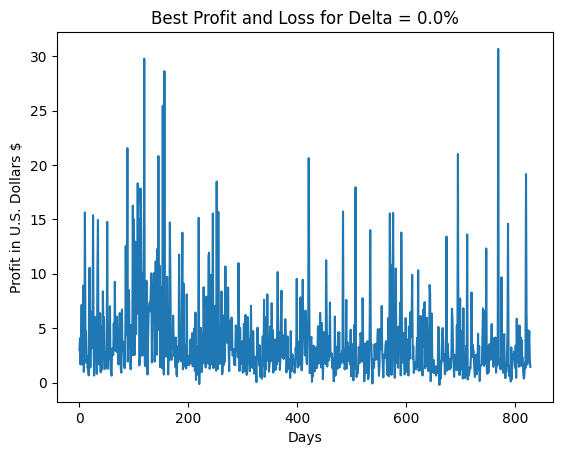

In [ ]:
test_pnl, test_num_profit_days, test_num_loss_days, test_num_neutral_days, capital = long_short_strat(data_val, delta_percent=best_delta_percent, cap_alloc_limit=0.5)

test_avg_pnl = sum(test_pnl) / len(test_pnl)

print(f'Delta = {best_delta_percent*100}% ===> Test Average PNL = {test_avg_pnl}$, Profitable Days = {test_num_profit_days}, Lossy Days = {test_num_loss_days}, Neutral Days = {test_num_neutral_days}, Sum PNL = {sum(test_pnl)}, Capital {capital}')


plt.title(f'Best Profit and Loss for Delta = {best_delta_percent*100}%')
plt.xlabel('Days')
plt.ylabel('Profit in U.S. Dollars $')
plt.plot(test_pnl)

In [ ]:
pd.DataFrame(test_pnl).describe()

,0
count,829.000000
mean,3.874264
std,3.895369
min,-0.214829
25%,1.532072
50%,2.535745
75%,4.769120
max,30.666113


In [ ]:
data_val["Max_Profit"] = data_val["High"] - data_val["Low"]

data_val["Max_Profit"].describe()

# print(data_val["Max_Profit"].sum())

C:\Users\vibkr\AppData\Local\Temp\ipykernel_18256\2517944834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val["Max_Profit"] = data_val["High"] - data_val["Low"]


count    829.000000
mean       5.043124
std        5.376262
min        0.270001
25%        1.599998
50%        3.350002
75%        6.320007
max       38.799988
Name: Max_Profit, dtype: float64